# Homework 3 - Andrew Schwartz - PHYS 403, SPR 2024

## 1. Properties of the Poisson Distribution 

Here you will verify three properties of the Poisson distribution
$$
p(m|\lambda)=\frac{\lambda^m}{m!}e^{-\lambda}
$$

### (a)

Show that $\langle m\rangle=\lambda$.

### Solution



### (b)

Show that $\text{var}(m)=\lambda$.

### Solution

### (c)

Suppose $x$ and $y$ are independent Poisson variables with means $λ_x$ and $λ_y$, respectively. Show that $z = x + y$ is also Poisson-distributed with mean $λ_z = λ_x + λ_y$, thus proving that the sum of two Poisson variables is another Poisson variable.


*Hint:* consider the joint probability $p(x, y|λ_x, λ_y)$. Noting that $x + y = z$, sum over all $x \in [0, z]$ such that $z = x + y$.

### Solution

## 2. Generating Gaussian Random Numbers

In class we discussed several different ways to generate Gaussian random numbers. In this problem, we will implement these methods to generate Gaussian random numbers with $\mu = 0$ and $σ^2 = 1$. Make sure that all plots are properly labeled.

In [255]:
import math

import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm, uniform, rayleigh, pearsonr

# rng is like 2x as fast if you use `np.random.default_rng().<random method>()` over `np.random.<random method>()
rng = np.random.default_rng()
π = np.pi

n = 10_000

In [325]:
def add_pdf(ax, dist, min=None, max=None, **kwargs):
    """Add a pdf for a given distribution to the provided plot"""
    x = np.linspace(
        min if min is not None else dist.ppf(0.001),
        max if max is not None else dist.ppf(0.999),
        1000
    )
    ax.plot(x, dist.pdf(x, **kwargs), label=f"{dist.name} PDF")


def plot(gaussian):
    """Plot a histogram for a given Gaussian sampling generator"""
    fig, ax = plt.subplots()
    # call the gaussian function and plot histogram
    ax.hist(gaussian(), density=True, bins=31, label="simulated")
    # plot the pdf of norm (Gaussian)
    add_pdf(ax, norm)
    ax.set_title(gaussian.__name__)
    ax.set_xlabel("x (units of σ)")
    ax.set_ylabel("Probability")
    ax.legend(frameon=False)
    plt.show()

### (a)

Write a function that uses the accept/reject method. Generate 10,000 random numbers, and plot them to show that they are Gaussian distributed. (Warning: this will be very slow if you try to go out to large values of $|x|$, so you may want to restrict the region to within a few $σ$ of the mean.)

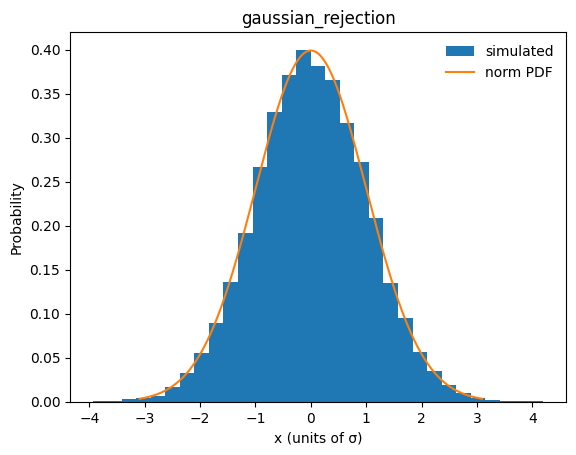

In [326]:
# max(g(x))
max_value = norm.pdf(0)
nσ = 5

# prob of accepting an xy pair (1/10 ∫₋₅⁵ e^(-x^2/2) dx)
prob_rejection_accepted = np.sqrt(2 * π) * math.erf(5 / np.sqrt(2)) / 10
# num random pairs usually needed to get 10000 accepted pairs 
# since its random, it won't always produce all 10000 values, but its close enough for this assignment, and it'd make the function significantly more complicated/ugly to loop until 10000
n_req_rejection = int(n / prob_rejection_accepted) + 1


def gaussian_rejection():
    x = rng.uniform(-nσ, nσ, n_req_rejection)
    y = rng.uniform(0, max_value, n_req_rejection)
    return x[y < norm.pdf(x)][:n]


plot(gaussian_rejection)

### (b)

Write a function that uses the central limit theorem, and random numbers generated from a uniform distribution. Generate 10,000 Gaussian random numbers, and plot the result.

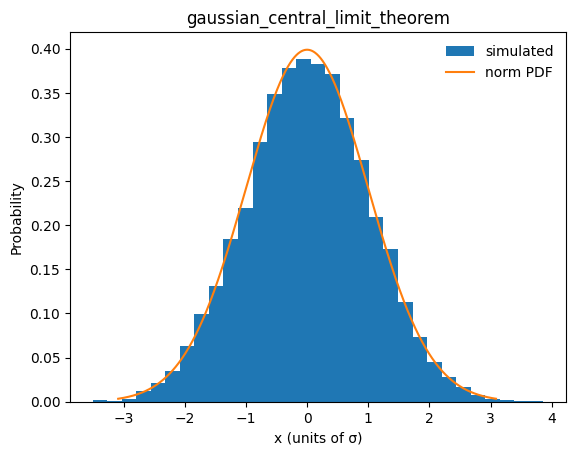

In [327]:
def gaussian_central_limit_theorem():
    return np.sum(rng.random((n, 12)), axis=1) - 6


plot(gaussian_central_limit_theorem)

### (c)

Write a function that applies the classic version of the Box-Müller algorithm. Generate 10,000 random numbers, and plot the result. (Hint: your function will actually produce pairs of independent random numbers, so you get two for each call.)

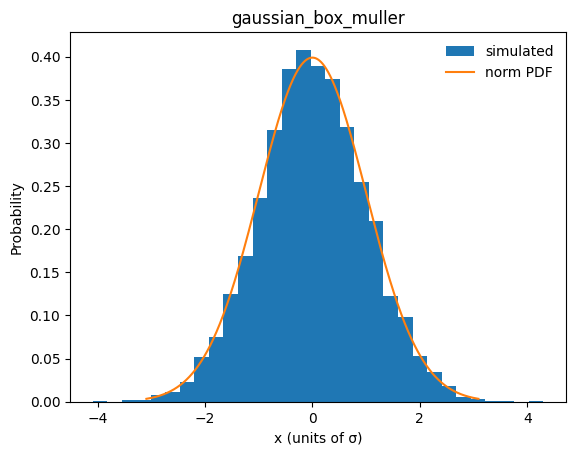

In [328]:
def gaussian_box_muller(concat=True):
    """Since this function is used for three separate parts, takes a param to figure out what to return
    concat = True -> return all 10000 numbers as 1d list
    concat = False -> return numbers as 2d (x, y) list of 5000 elements each
    concat = None -> return r, Θ distributions
    """
    θ = rng.uniform(0, 2 * π, n // 2)
    u = rng.random(n // 2)
    r = np.sqrt(-2 * np.log(u))
    if concat is None:
        return r, θ
    x = r * np.cos(θ)
    y = r * np.sin(θ)
    return np.concatenate((x, y)) if concat else (x, y)


plot(gaussian_box_muller)

### (c)

Using your Box-Müller function, show that the $x, y$ pair are independent. (Hint: make a 2D scatter plot.)

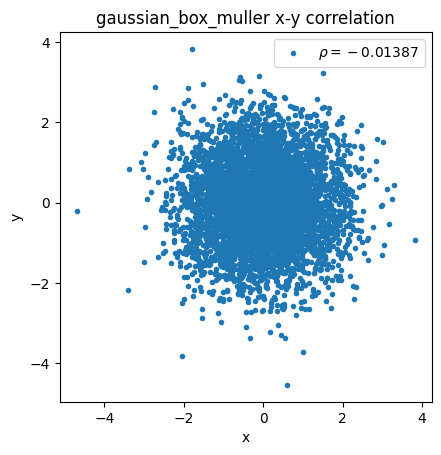

In [329]:
def scatter_plot(f):
    x, y = f(concat=False)
    fig, ax = plt.subplots(figsize=(4.8, 4.8))
    rho = pearsonr(x, y)[0]
    ax.scatter(x, y, marker='.', label=f"$\\rho={rho:.4}$")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_title(f"{f.__name__} x-y correlation")
    ax.legend()
    plt.show()


scatter_plot(gaussian_box_muller)

### (d)

Modify your Box-Müller function to return polar variables. Show that $θ$ is distributed uniformly, and $r$ is a Rayleigh distribution.

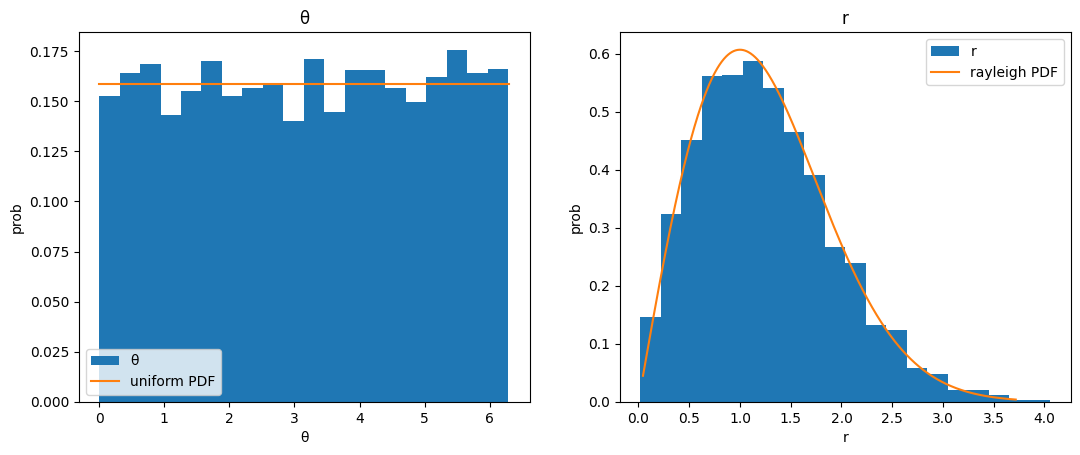

In [330]:
# get the polar variables
r, θ, = gaussian_box_muller(concat=None)
fig, ax = plt.subplots(1, 2, figsize=(6.4 * 2, 4.8))
# plot θ and the uniform distribution
ax[0].set_title("θ")
ax[0].set_xlabel("θ")
ax[0].hist(θ, density=True, bins=20, label="θ")
add_pdf(ax[0], uniform, max=6.3, scale=6.3)
# plot r and the Rayleigh distribution 
ax[1].set_title("r")
ax[1].set_xlabel("r")
ax[1].hist(r, density=True, bins=20, label="r")
add_pdf(ax[1], rayleigh)

for ax in ax:
    ax.legend()
    ax.set_ylabel("prob")

plt.show()

### (f)

Write a function that implements the Marsaglia method. Show that it also produces pairs of independent, Gaussian distributed random numbers.

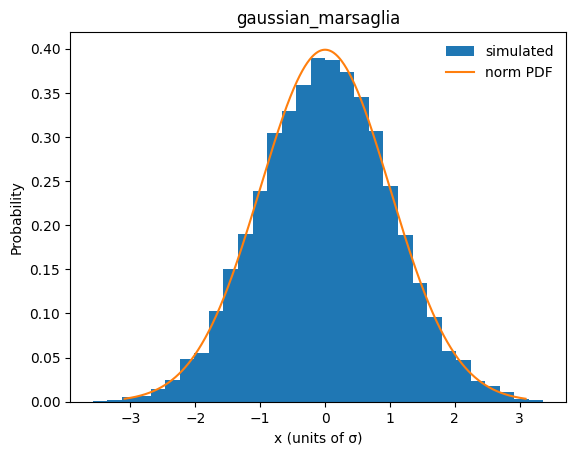

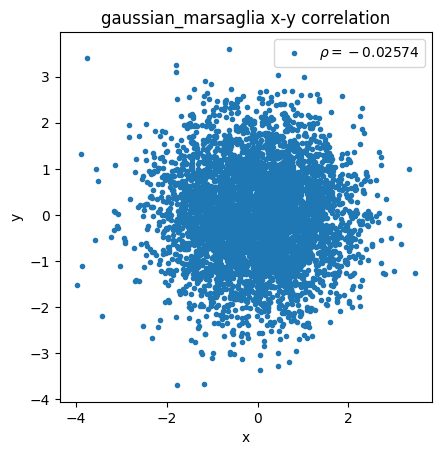

In [331]:
# only ≈78% of xy pairs are accepted, so we overshoot by that much to make sure we get 10000 numbers
prob_marsaglia_accepted = π / 4
# num random pairs usually needed to get 10000 accepted pairs 
# again, not always exactly 10000 but close enough for our purposes
n_req_marsaglia = int(n / 2 / prob_marsaglia_accepted) + 1


def gaussian_marsaglia(concat=True):
    xy = rng.uniform(-1, 1, (2, n_req_marsaglia))
    s = np.sum(xy ** 2, axis=0)
    accept = s <= 1
    xy = xy[:, accept]
    s = s[accept]
    r = np.sqrt(-2 * np.log(s) / s)
    return np.reshape(r * xy, -1)[:n] if concat else (x, y)

plot(gaussian_marsaglia)
scatter_plot(gaussian_marsaglia)

### (g)

Extra credit: Determine the time performance of each technique in this problem to generate a very large sequence of Gaussian random numbers (there are many ways to do this, you can use the UNIX time command, or python’s time package, for example). Compare the result to a built-in Gaussian RNG (like numpy.random.normal). Quantify what is meant by some things being “slow.”

In [333]:
from timeit import timeit
from prettytable import PrettyTable

iters = 1_000


def gaussian_numpy():
    return rng.normal(size=n)


functions = [
    gaussian_numpy,
    gaussian_rejection,
    gaussian_central_limit_theorem,
    gaussian_box_muller,
    gaussian_marsaglia
]

# round to 6 sig figs in the table
sig_figs = lambda cols, n=6: {key: (lambda _, v: f'{v:.{n}g}') for key in cols}

time = "time/iter (μs)"
t = PrettyTable(["functions", time], sortby=time, align='l', custom_format=sig_figs([time], 8))
# time each function `iters` times, print the avg time to generate 10000 numbers
t.add_rows([[fn.__name__, timeit(fn, number=iters) / iters * 1e6] for fn in functions])
print(t)

+--------------------------------+----------------+
| functions                      | time/iter (μs) |
+--------------------------------+----------------+
| gaussian_numpy                 | 195.4417       |
| gaussian_box_muller            | 438.6348       |
| gaussian_marsaglia             | 653.3528       |
| gaussian_central_limit_theorem | 1237.5231      |
| gaussian_rejection             | 3955.9877      |
+--------------------------------+----------------+


On my computer, `gaussian_numpy` is the fastest, usually taking around 125μs. The fastest method implemented by hand is `gaussian_box_muller`, taking about 50% longer (190 μs). Interestingly, 'gaussian_marsaglia' is slower still, despite being what numpy's normal method uses (250 μs). The difference is in C, numpy only has to allocate the 10000-element array once, whereas using numpy from Python has to allocate six arrays of that size, leading to the 2x slower speed. The other two methods `gaussian_central_limit_theorem` and `gaussian_rejection` are just wildly slow, taking around 500 μs and ~2 ms to generate the 10000 numbers. Again, the central limit theorem has to compute 12 times as many uniform random numers as numpy's Gaussian, so it is another 2x slower than marsaglia.

In Monte Carlo experiments, it is not uncommon to be generating billions of Gaussian numbers, so the ~60 μs extra from using the best handwritten generator amounts to on the order of 1 day of extra compute time. 

## 3. Monte Carlo Integration: the Gamma Function

The integral of a 1D function f(x) on the interval [a, b] can be approximated by
$$
I=\int_a^bf(x)dx\approx(b-a)\langle f(x)\rangle,\qquad\qquad\langle f(x)\rangle\frac{1}{N}\sum_{i=1}^Nf(x_i),
$$
where the ${x_i}$ are a set of random uniformly distributed points on the interval $a\leq x\leq b$. The uncertainty on the integral is approximately
$$
\Delta I\approx(b-a)\sqrt{\frac{\langle f^2(x)\rangle-\langle f(x)\rangle^2}{N}}.
$$
The gamma function is defined by
$$
\Gamma(z)=\int_0^\infty x^{z-1}e^{-x}dx
$$
where z can be a complex number in general. For simplicity, let's assume z is real.

*Hint:* for integer values, $\Gamma(n) = (n − 1)!$, the factorial function. You can use this to check your implementation of the gamma function.

*Hint:* to transform the infinite range of integration to a finite one, you may wish to make the change of variables $u = 1/(1 + x)$.


### (a)

Write a function to compute $\Gamma(z)$ and the uncertainty on $\Gamma(z)$ using Monte Carlo integration.

### Solution

$u=\frac{1}{1+x}$ ⇒ $x=\frac{1}{u}-1$
$(u(0)=1,\quad u(\infty)=0$

$$ \Gamma(z)=-\int_0^1\frac{e^{1-\frac{1}{u}}\left(\frac{1}{u}-1\right)^z}{u(u-1)} du $$

$$ f_z(u)=-\frac{e^{1-\frac{1}{u}}\left(\frac{1}{u}-1\right)^z}{u(u-1)} $$

In [334]:
f = lambda z, u: -(np.exp(1 - 1 / u) * np.power(1 / u - 1, z)) / (u * (u - 1))


def gamma_mc(z, n: int = 100_000):
    fi = f(z, rng.random(n))
    return np.mean(fi), np.std(fi) / np.sqrt(n)


# test vs integers to double-check w/ factorials
cols = ["Γ(n)", "σ"]
t = PrettyTable(["n", "(n-1)!", *cols], custom_format=sig_figs(cols))
t.add_rows(
    [[n, math.factorial(n - 1), *gamma_mc(n)] for n in range(1, 7)]
)
print(t)

+---+--------+----------+------------+
| n | (n-1)! |   Γ(n)   |     σ      |
+---+--------+----------+------------+
| 1 |   1    |  1.0022  | 0.00157762 |
| 2 |   1    | 0.998817 | 0.00273477 |
| 3 |   2    |  1.9901  | 0.00780478 |
| 4 |   6    | 5.96314  |  0.02954   |
| 5 |   24   | 24.1486  |  0.141385  |
| 6 |  120   | 119.693  |  0.807487  |
+---+--------+----------+------------+


### (b)

Compute $\Gamma(5)$ and $\Gamma(\pi)$ using 100, $10^4$, and $10^6$ samples, and report the uncertainties. (Reporting the values to about 6 significant figures should be sufficient.)

In [335]:
cols = ["Γ(5)", "σ_5", "true Γ(π)", "Γ(π)", "σ_π"]

t = PrettyTable(["samples", "4!", *cols], custom_format=sig_figs(cols))
t.add_rows(
    [[n, math.factorial(4), *gamma_mc(5, n), math.gamma(π), *gamma_mc(π, n)] for n in [100, 10 ** 4, 10 ** 6]]
)
print(t)

+---------+----+---------+-----------+-----------+---------+------------+
| samples | 4! |   Γ(5)  |    σ_5    | true Γ(π) |   Γ(π)  |    σ_π     |
+---------+----+---------+-----------+-----------+---------+------------+
|   100   | 24 | 25.4695 |  4.75486  |  2.28804  | 2.56359 |  0.316675  |
|  10000  | 24 | 23.4796 |  0.441598 |  2.28804  | 2.32149 | 0.0293929  |
| 1000000 | 24 | 23.9523 | 0.0444541 |  2.28804  | 2.28759 | 0.00294051 |
+---------+----+---------+-----------+-----------+---------+------------+


### (c)

Using $10^6$ samples, compute $\Gamma(90)$. Do you encounter a numerical overflow? How might you change your code to avoid this? Make the change and compute $\Gamma(90)$.


In [336]:
gamma_mc(90)

C:\Users\andre\AppData\Local\Temp\ipykernel_23704\3383349800.py:1: RuntimeWarning: overflow encountered in power
  f = lambda z, u: -(np.exp(1 - 1 / u) * np.power(1 / u - 1, z)) / (u * (u - 1))
C:\Users\andre\AppData\Local\Temp\ipykernel_23704\3383349800.py:1: RuntimeWarning: invalid value encountered in multiply
  f = lambda z, u: -(np.exp(1 - 1 / u) * np.power(1 / u - 1, z)) / (u * (u - 1))


(nan, nan)

Oh no! An overflow!

To fix this, we rewrite gamma_mc and f to use a big number library (I chose gmpy2, a binding to the mpfr C library).

In [337]:
# big number library
import gmpy2 as gp

# explicit random state needed for gp
gprng = gp.random_state(int(rng.integers(np.iinfo(int).max)))

f_big = lambda z, u: -(gp.exp(1 - 1 / u) * np.power(1 / u - 1, z)) / (u * (u - 1))


def gamma_mc_big(z, n: int):
    fi = np.array([f_big(z, gp.mpfr_random(gprng)) for _ in range(n)])
    mean = np.mean(fi)
    return mean, gp.sqrt(np.sum(np.power(fi - mean, 2)) / (n - 1) / n)


t = PrettyTable(["89!", "Γ(90)", "σ"])
t.add_row([gp.factorial(89), *gamma_mc_big(90, 100000)])
print(t)

+------------------------+-------------------------+-------------------------+
|          89!           |          Γ(90)          |            σ            |
+------------------------+-------------------------+-------------------------+
| 1.650795516090846e+136 | 1.6493482788091305e+136 | 8.2265819261146628e+134 |
+------------------------+-------------------------+-------------------------+
